In [1]:
import time
import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix
df = pd.read_csv('./dataset/Apply_Rate_2019.csv').drop(['search_date_pacific', 'class_id'], axis=1)
df.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply
0,0.000000,0.000000,0.000000,0.004824,0.006628,0.0,5.0,0
1,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,0
2,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,1
3,0.000000,0.000000,3.695809,0.013046,0.033340,0.0,5.0,0
4,NaN,NaN,7.868900,0.008065,0.008772,0.0,7.0,0


In [2]:
# start fking preprocessing
df.drop_duplicates(inplace=True)  # (len(df)=1112618, len(df[df['apply']==1])=99595), imbalanced
df.fillna(df.mean(), inplace=True)
df.describe()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply
count,1.083825e+06,1.083825e+06,1.083825e+06,1.083825e+06,1.083825e+06,1.083825e+06,1.083825e+06,1.083825e+06
mean,6.027094e+00,9.819553e-02,1.878621e+00,1.713955e-02,3.617481e-02,5.555732e-01,1.053496e+01,9.061057e-02
std,8.905327e+00,2.599248e-01,2.255461e+00,1.247846e-02,4.943090e-02,4.382087e-01,1.785121e+01,2.870546e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-06,9.998021e-07,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.041667e-02,1.228964e-02,0.000000e+00,2.000000e+00,0.000000e+00
50%,0.000000e+00,2.790926e-02,7.994508e-01,1.562500e-02,2.042031e-02,5.555732e-01,6.000000e+00,0.000000e+00
75%,8.050585e+00,9.819553e-02,3.576873e+00,2.070356e-02,3.826712e-02,1.000000e+00,1.500000e+01,0.000000e+00
max,9.351672e+01,7.301161e+00,1.774189e+01,2.556893e-01,1.294088e+00,1.000000e+00,1.340000e+03,1.000000e+00


In [3]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

train_x, test_x = train_test_split(df, test_size=0.2, random_state=4211)
#train_x, val_x = train_test_split(train_x, test_size=0.2)
train_y = train_x.pop('apply')
#val_y = val_x.pop('apply')
test_y = test_x.pop('apply')

train_x, train_y = RandomUnderSampler(random_state=0).fit_resample(train_x, train_y)
train_x.shape

Using TensorFlow backend.


(157010, 7)

In [4]:
# Normalise the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
#val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)

x_columns = df.drop('apply',axis=1).columns

train_x = pd.DataFrame(train_x, columns = x_columns)
#val_x = pd.DataFrame(val_x, columns = x_columns)
test_x = pd.DataFrame(test_x, columns = x_columns)

train_x.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days
0,-0.702256,0.262848,-0.871800,-0.157086,-0.453013,-1.285282,-0.362017
1,-0.702256,0.332947,-0.871800,-0.135075,-0.382476,-1.285282,-0.597592
2,0.421174,0.997271,0.283075,-0.332972,-0.371211,-1.285282,-0.362017
3,-0.702256,-0.211085,2.043604,1.239766,-0.092200,-1.285282,0.698073
4,-0.702256,-0.367700,-0.871800,0.654778,-0.357324,-1.285282,0.521391


In [5]:
clf = LinearSVC() # default max_iter=1000

start = time.time()
clf.fit(train_x, train_y)
print(time.time()-start)

27.569960832595825


C:\Users\alanh\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.92      0.68      0.78    197064
           1       0.12      0.43      0.18     19701

    accuracy                           0.65    216765
   macro avg       0.52      0.55      0.48    216765
weighted avg       0.85      0.65      0.73    216765



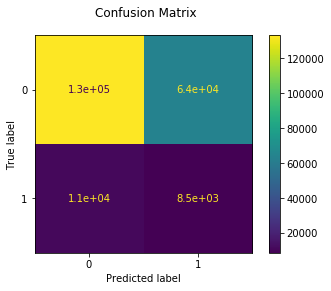

In [6]:
def report(clf):
    pred_y = clf.predict(test_x)

    print(classification_report(test_y, pred_y))
    disp = plot_confusion_matrix(clf, test_x, test_y)
    disp.figure_.suptitle("Confusion Matrix")
    
report(clf)

In [ ]:
clf = SVC()  # so fking slow even after normalisation, run for hrs still no output so I terminated this. 
            # Probably data size is too large for this, because it takes quadratic time to run (found from web).

start = time.time()
clf.fit(train_x, train_y)
print(time.time()-start)

report(clf)